In [1]:
options(tidyverse.quiet = TRUE)
library(tidyverse)

source("../R/priors.R")
source("../R/functions.R")

## Comparison of required sample sizes by power-constraint criterion

In [2]:
# maximal sample size cut-off
nmax             <-  1000
# lowest and highest plausible values of the location parameter theta
prior_lo         <- -1.0
prior_hi         <-  1.0
# range of prior means for location parameter
prior_mean_range <- seq(0, .5, by = .01)
# range of prior standard deviations for location parameter
prior_sd_range   <- seq(.01, 1, by = .01)
# one sided maximal type one error rate
alpha            <- 0.025
# minimal power/expected power/probability of success is 1 - beta
beta             <- 0.2
# upper boundary of the null hypothesis for the location parameter 
# H0: theta <= theta_null
theta_null       <- 0.0
# minimal clinically important difference (MCID)
theta_mcid       <- theta_null

In [3]:
tbl_grid <- expand_grid(
        mu  = prior_mean_range ,
        tau = prior_sd_range
    ) %>%
    mutate(
        prior          = map2(mu, tau, ~Normal(.x, .y, lo = prior_lo, hi = prior_hi)),
        `quantile 0.5` = map_dbl(prior, ~get_n_quantile(theta_null, ., .5, pwr = 1 - beta, alpha = alpha, upper_n = nmax)),
        `quantile 0.9` = map_dbl(prior, ~get_n_quantile(theta_null, ., .9, pwr = 1 - beta, alpha = alpha, upper_n = nmax)),
        EP             = map_dbl(prior, ~get_n_ep(theta_null, ., pwr = 1 - beta, alpha = alpha, upper_n = nmax)),
        PoS            = map_dbl(prior, ~get_n_pos(theta_null, ., pwr = 1 - beta, alpha = alpha, upper_n = nmax))
    ) %>%
    pivot_longer(
        c(contains('quantile'), EP, PoS), 
        values_to = 'required sample size', 
        names_to  = 'criterion'
    )

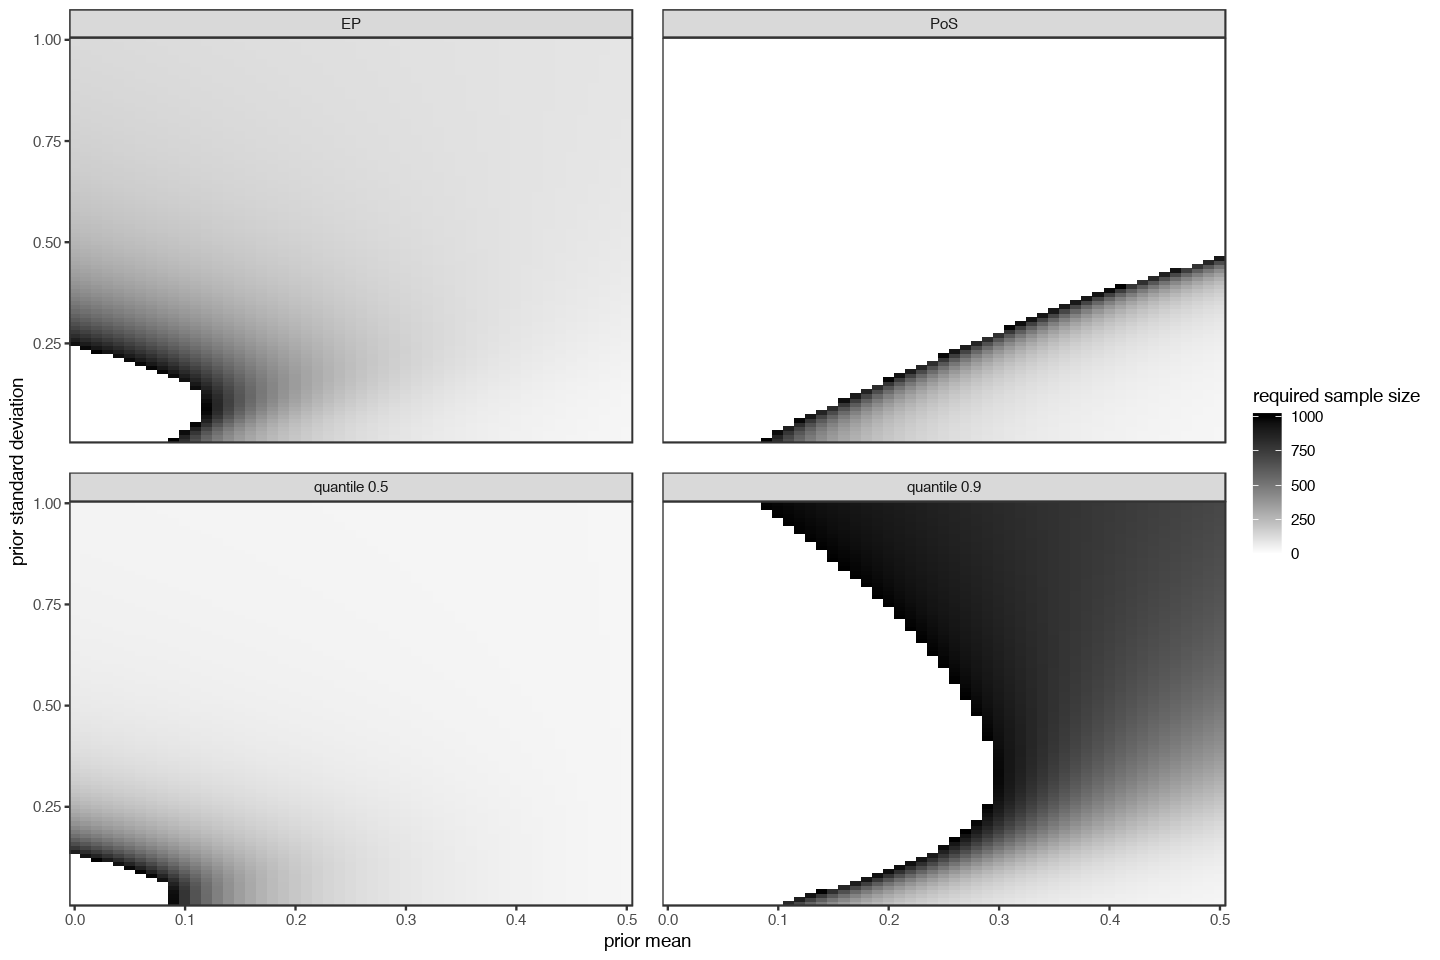

In [4]:
options(repr.plot.width = 12, repr.plot.height = 8)

tbl_grid %>% 
    filter(
        `required sample size` <= nmax, # make sure maximal sample size is respected
        !is.na(`required sample size`)  # throw out instances where the maximal sample size boundary was hit
    ) %>% 
    ggplot() +
        aes(mu, tau, fill = `required sample size`, z = `required sample size`) +
        geom_tile() + # geom_raster leads to some pdf viewers interpolating, do not want that!
        scale_fill_gradient(limits = c(0, 1000), low = '#FFFFFF', high = '#000000') +
        coord_cartesian(expand = FALSE) +
        xlab('prior mean') +
        ylab('prior standard deviation') +
        facet_wrap(~criterion) +
        theme_bw() +
        theme(
            panel.grid      = element_blank(),
            panel.spacing   = unit(1.25, 'lines'),
            legend.position = 'right'
        )

# save plot as pdf
ggsave('../latex/figures/power-constraint-comparison.pdf', width = 8, height = 6)